# Needed classes

In [97]:
import math
class Area:
    def __init__(self, start, end, name=""):
        if start >= end:
            raise ValueError
        self.start = start
        self.end = end
        self.name = name

    def __len__(self):
        return self.end - self.start

    def middle(self):
        return self.start + math.ceil(len(self) / 2)

    def contains(self, value):
        return self.start <= value < self.end

  
class ChromosomeAreas:
    def __init__(self, islands=None, shores=None, shelves=None, seas=None):
        self.areas = {
            'islands': ChromosomeAreas.init_array(islands),
            'shores': ChromosomeAreas.init_array(shores),
            'shelves': ChromosomeAreas.init_array(shelves),
            'seas': ChromosomeAreas.init_array(seas)
        }

    @classmethod
    def init_array(cls, array):
        return [] if array is None else array

    def add(self, other):
        for key in self.areas:
            self.areas[key] += other.areas[key]

# Useful methods

In [98]:
import re
def validate_regex(name):
    regex = r'^chr([1-9]|1[0-9]|2[0-2])$'
    regex = re.compile(regex)
    return regex.match(name)

def write_to_file(file, areas, chromosome):
    for area in areas:
        file.write('%s\t%d\t%d\n' % (chromosome, area.start, area.end))

# Constants

In [99]:
AREAS = ['islands', 'shores', 'shelves', 'seas']
BORDER = 2000
BED_FIRST_INDEX = 0

 # 1st task

Split area before first island

In [100]:
def find_beginning(first_island_start):
    shore = next_area_beginning(Area(BED_FIRST_INDEX, first_island_start))
    if shore.start == BED_FIRST_INDEX:
        return ChromosomeAreas(shores=[shore])
    shelf = next_area_beginning(Area(BED_FIRST_INDEX, shore.start))
    if shelf.start == BED_FIRST_INDEX:
        return ChromosomeAreas(shores=[shore], shelves=[shelf])
    return ChromosomeAreas(shores=[shore], shelves=[shelf], seas=[Area(BED_FIRST_INDEX, shelf.start)])


def next_area_beginning(area):
    if len(area) < BORDER:
        return area
    return Area(area.end - BORDER, area.end)

Methods splitting areas between islands

In [101]:
def find(between_islands):
    shores = next_areas(between_islands)
    if len(shores) == 1:
        return ChromosomeAreas(shores=shores)
    shelves = next_areas(Area(shores[0].end, shores[1].start))
    if len(shelves) == 1:
        return ChromosomeAreas(shores=shores, shelves=shelves)
    return ChromosomeAreas(shores=shores, shelves=shelves, seas=[Area(shelves[0].end, shelves[1].start)])


def next_areas(area):
    if len(area) <= 2 * BORDER:
        return [area]
    return [Area(area.start, area.start + BORDER), Area(area.end - BORDER, area.end)]

Methods splitting area after last island

In [102]:
def find_ending(last_island_end, size):
    shore = next_area_ending(Area(last_island_end, size))
    if shore.end == size:
        return ChromosomeAreas(shores=[shore])
    shelf = next_area_ending(Area(shore.end, size))
    if shelf.end == size:
        return ChromosomeAreas(shores=[shore], shelves=[shelf])
    return ChromosomeAreas(shores=[shore], shelves=[shelf], seas=[Area(shelf.end, size)])


def next_area_ending(area):
    if len(area) < BORDER:
        return area
    return Area(area.start, area.start + BORDER)

Read chromosome sizes

In [103]:
sizes = {}
with open('data/sizes.txt') as sizes_file:
    for line in sizes_file.readlines():
        split_line = line.split('\t')
        sizes[split_line[0]] = int(split_line[1])

Read chromosome islands (grouped by chromosome name)

In [104]:
chromosomes = {}
with open('data/cpgIslandExt.txt') as islands_input_file:
    for line in islands_input_file.readlines():
        split_line = line.split('\t')
        name = split_line[1]
        if validate_regex(name):
            if name not in chromosomes:
                chromosomes[name] = ChromosomeAreas()
            chromosomes[name].areas['islands'].append(Area(int(split_line[2]), int(split_line[3])))

For each chromosome calculate areas and save to specific files

In [105]:
files = {}
for area in AREAS:
    files[area] = open('results/' + area + '.bed', 'w+')
for key in chromosomes:
    islands = sorted(chromosomes[key].areas['islands'], key=lambda x: x.start)
    beginning = find_beginning(islands[0].start)
    chromosomes[key].add(beginning)
    for i in range(0, len(islands) - 1):
        areas = find(Area(islands[i].end, islands[i + 1].start))
        chromosomes[key].add(areas)
    ending = find_ending(islands[len(islands) - 1].end, sizes[key])
    chromosomes[key].add(ending)
    for file_key in files:
        write_to_file(files[file_key], chromosomes[key].areas[file_key], key)
for key in files:
    files[key].close()

# 2nd and 3rd tasks

Find area in specific chromosome, that contains middle of methylation area

In [106]:
def find_dna_methylation(methylation_area, chromosome_areas):
    middle = methylation_area.middle()
    for i, area in enumerate(chromosome_areas):
        if area.contains(middle):
            return area.name, i
    raise ValueError

Read files calculated in 1st task

In [107]:
areas = {}
for area in AREAS:
    with open('results/' + area + '.bed') as file:
        for line in file.readlines():
            split_line = line.split('\t')
            name = split_line[0]
            if name not in areas:
                areas[name] = []
            areas[name].append((Area(int(split_line[1]), int(split_line[2]), area)))
for key in areas:
    areas[key] = sorted(areas[key], key=lambda x: x.start)

Read file with DNA methylations

In [108]:
methylations = {}
with open('data/dnaMethylation.bed') as islands_input_file:
    for line in islands_input_file.readlines():
        split_line = line.split('\t')
        name = split_line[0]
        if validate_regex(name):
            if name not in methylations:
                methylations[name] = []
            methylations[name].append(Area(int(split_line[1]), int(split_line[2])))

For all dna methylations in every chromosome find name of the area, which contains middle 

In [109]:
found_areas = []
for key in methylations:
    methylations_chr = sorted(methylations[key], key=lambda x: x.start)
    i = 0
    for meth_key in methylations_chr:
        area_name, j = find_dna_methylation(meth_key, areas[key][i::])
        found_areas.append(area_name)
        i += j

Visualize distribution of DNA methylation middles in different areas

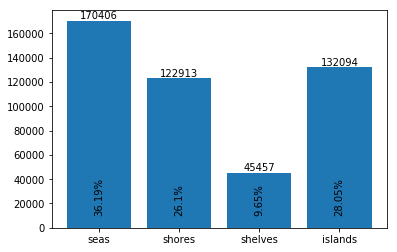

In [110]:
import collections
import matplotlib.pyplot as plt
counter = collections.Counter(found_areas)
bar_plot = plt.bar(counter.keys(), counter.values())
for rect in bar_plot:
    height = rect.get_height()
    perc = str(round(height * 100 / len(found_areas), 2)) + '%'
    plt.text(rect.get_x() + rect.get_width()/2., height, height, ha='center', va='bottom', rotation=0)
    plt.text(rect.get_x() + rect.get_width()/2., 1e4, perc, ha='center', va='bottom', rotation=90)